In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import gc
import random
from   tqdm import tqdm
from   sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
import psutil
import datatable as dt
from   collections import namedtuple
import os
import seaborn as sns
from   sklearn.utils import shuffle
import datetime
import time
from   copy import deepcopy as copy
from   sklearn.metrics import accuracy_score, precision_recall_fscore_support, matthews_corrcoef, roc_auc_score
from   sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from   torch.utils.data import RandomSampler, SequentialSampler  #, Dataset, DataLoader
from   transformers import get_linear_schedule_with_warmup

import fastai
from   fastai.callback import *
from   fastai.callback.all import *
from   fastai.callback.training import GradientClip
from   fastai.callback.all import SaveModelCallback, EarlyStoppingCallback, ReduceLROnPlateau 
from   fastai.tabular import *
from   fastai.tabular.data import *
from   fastai.tabular.all import *
from   fastai.tabular.all import TabularPandas, RandomSplitter, CategoryBlock, MultiCategoryBlock, range_of, accuracy, tabular_learner, TabularDataLoaders
# from   fastai import datasets
# from   fastai.dataset import ModelData,ArraysIndexDataset
# from   fastai.dataloader import DataLoader
from   fastai.learner import Learner

from   functools import partial

from   sklearn.pipeline import Pipeline
from   sklearn.impute import SimpleImputer
from   sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings ("ignore")

In [3]:
Datasets, DataLoader, DataLoaders

(fastai.data.core.Datasets,
 fastai.data.load.DataLoader,
 fastai.data.core.DataLoaders)

In [4]:
# Global Vars
BS     = 10000
TP     = None
DF     = None
DLs    = None
PIPE   = None
F_COLS = None
R_COLS = None
EMB5_MODEL = None
N_FEATURES = 0
TRAIN_DL   = None # train DataLoader 
VAL_DL     = None   # valid DataLoader
HIST_LEN   = 500

In [5]:
dtype = {
    'feature'  : 'str', 
    'tag_0'    : 'int8'
}
for i in range (1, 29):
    k = 'tag_' + str (i)
    dtype[k] = 'int8'
    
features_df = pd.read_csv ('../input/jane-street-market-prediction/features.csv', usecols=range (1,30), dtype=dtype)
N_FEATURES  = features_df.shape[0]  # the features.csv has 130 features (1st row) = no of features in train.csv (feature_0 to feature_129)
N_FEAT_TAGS = features_df.shape[1]  # the features.csv has 29 tags
# features_df.head ()
del features_df
gc.collect ()
N_FEATURES, N_FEAT_TAGS

(130, 29)

In [6]:
def preprocess_data (filename='../input/jane-street-market-prediction/train.csv.dummy', df=None, isTrainData=True):
    
    global PIPE, F_COLS, R_COLS
    dtype = None
    if isTrainData:
        
        dtype = {
            'date'      : 'int64', 
            'weight'    : 'float32',
            'resp'      : 'float32',
            'ts_id'     : 'int64',  
            'feature_0' : 'float32'
        }
    else:
        
        dtype = {
            'date'      : 'int64', 
            'weight'    : 'float32',
            'feature_0' : 'float32'
        }
    for i in range (1, 130):
        k = 'feature_' + str (i)
        dtype[k] = 'float32'
    
    to = None
    df = None
    if isTrainData:
        df         = pd.read_csv (filename, dtype=dtype)
        df         = df.query ('date > 85')
        df         = df[df['weight'] != 0].reset_index (drop = True)
        
        R_COLS     = ['resp_1', 'resp_2', 'resp_3','resp_4', 'resp']    
        # df[:5000].to_csv (filename+'.dummy', index=False) 
        y          = np.stack ([(df[c] > 0).astype ('int') for c in R_COLS]).T
        df.drop (columns=['weight', 'date', 'ts_id']+R_COLS, inplace=True)
        F_COLS     = [c for c in df.columns if "feature" in c]
        PIPE       = Pipeline ([
                        ("imputer", SimpleImputer (missing_values=np.nan, strategy='mean')),
                        # ("stand",   StandardScaler (with_mean=False))
        ])
        columns    = list (df.columns) + R_COLS
        X          = PIPE.fit_transform (df)
        df         = pd.DataFrame (np.hstack ((X, y)))
        df.columns = columns
        del X, y
        
        splits     = RandomSplitter (valid_pct=0.05) (range_of (df))
        to         = TabularPandas (df, cont_names=F_COLS, cat_names=None, y_names=R_COLS, y_block=MultiCategoryBlock(encoded=True, vocab=R_COLS), splits=splits)        
        return to, df
    else:
        
        df         = df.drop (columns=['weight', 'date']).reset_index (drop = True)
        columns    = df.columns
        X          = PIPE.transform (df)
        df         = pd.DataFrame (X)
        df.columns = columns
        # del X            
        return to, df

In [7]:
TP, DF = preprocess_data ()
TP.xs.iloc[:2]

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129
4199,1.0,0.079090,2.116994,0.363790,0.810077,-0.319050,-0.638149,1.119922,3.032730,-0.890097,...,-0.257776,2.195189,-1.357857,-1.184972,-0.237498,2.246579,-0.365514,1.652337,-1.203238,-0.397621
4285,-1.0,-0.749787,-0.696183,-2.939075,-3.331175,-6.672603,-7.583367,-1.989951,-2.625277,1.304397,...,1.036693,0.240109,0.631677,-0.735273,0.683545,-0.499444,0.942777,-0.498379,0.744161,-0.593055


In [8]:
DF.head ()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_125,feature_126,feature_127,feature_128,feature_129,resp_1,resp_2,resp_3,resp_4,resp
0,1.0,3.151305,5.467693,-0.164505,-0.189219,0.663966,0.988896,0.041933,0.023107,2.184804,...,4.331030,2.553220,3.799011,2.642943,3.998054,0.0,0.0,0.0,0.0,0.0
1,-1.0,-0.365888,0.824004,-0.293208,-0.416391,-0.599185,-0.997330,0.041933,0.023107,-0.869330,...,4.133183,-1.207878,3.402796,-0.928290,3.511141,1.0,0.0,0.0,0.0,0.0
2,1.0,1.514607,0.596214,0.324062,0.154730,0.845069,0.521491,0.041933,0.023107,0.310387,...,4.613493,4.516109,3.341374,2.635798,1.535235,1.0,1.0,0.0,0.0,1.0
3,-1.0,-1.008999,0.242132,-0.076187,-0.073584,-0.330932,-0.634109,0.041933,0.023107,-2.315807,...,1.645537,-1.318172,1.369452,-1.352576,0.733124,1.0,1.0,0.0,0.0,0.0
4,-1.0,-0.391784,0.152261,-0.603803,-0.711527,-1.204166,-1.579647,0.041933,0.023107,-1.926413,...,2.949878,-2.033542,2.248799,-1.838696,1.905638,1.0,1.0,1.0,1.0,1.0


In [9]:
DLs = TP.dataloaders (bs=BS)
DLs.show_batch ()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,feature_79,feature_80,feature_81,feature_82,feature_83,feature_84,feature_85,feature_86,feature_87,feature_88,feature_89,feature_90,feature_91,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,feature_100,feature_101,feature_102,feature_103,feature_104,feature_105,feature_106,feature_107,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,feature_116,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,resp_1,resp_2,resp_3,resp_4,resp
0,-1.0,-0.713839,-0.268261,-0.486405,-0.565431,-1.148021,-1.502452,0.041933,0.023107,-1.402398,-0.741073,-1.418300,-2.797995,0.466426,0.914227,-1.079817,-1.288776,0.124517,0.099811,-0.422740,-0.679221,-2.919710,-2.319005,-0.357085,-0.609225,-0.483308,-0.733138,0.140639,0.180904,0.388158,0.738679,0.685296,1.573227,1.143085,1.807628,0.686923,0.975338,-0.782771,-1.084148,0.197984,0.432715,8.940586,-3.204353,-0.918633,-0.501938,1.255588,-0.096371,-0.884003,-0.581895,-0.291385,1.912954,5.609293,2.337896,-2.419713,-0.190391,0.434431,0.373225,1.251686,2.050188,1.149365,-1.033412,-0.866227,-1.146050,-1.237420,-2.839077,-1.236160,-0.857475,-1.580923,-1.520412,-0.754977,3.460446,-0.181478,0.118366,0.222541,-0.056285,0.542955,0.158316,0.124693,0.141826,0.638040,-0.406989,2.647661,0.423757,-0.188005,1.045944,-0.078240,0.167757,0.307411,-0.320207,-1.662068,1.447023,1.013695,2.658406,2.821055,0.728116,-0.239761,1.068505,-1.338859,0.265117,-0.446759,-0.470246,-1.429855,1.481086,-0.940190,2.453729,0.769094,0.026918,-0.229915,1.185998,-2.311855,0.126439,-0.301784,-1.981169,-2.074370,1.460399,-0.576117,3.239120,2.455254,0.345684,-0.181560,-1.518724,2.199555,-2.148027,0.434164,-1.357129,2.226807,-2.412155,1.438557,-2.180290,1.125590,True,True,True,True,True
1,1.0,4.190912,0.790829,-2.461037,-0.901529,-3.480929,-1.375299,-3.243520,-1.832464,-1.814910,-1.600502,6.957473,4.004547,13.815534,5.152293,-0.230075,-1.636256,6.225949,3.438644,1.433599,0.301399,12.724837,4.361032,14.534816,7.344823,2.168402,0.536703,-3.600987,-2.369868,-0.409682,-0.173585,-2.077118,-1.886938,-3.616480,-1.974266,-5.464904,-2.759819,2.975461,1.253825,-4.000735,-2.708780,-0.441402,5.965267,7.189540,4.821633,2.948821,0.056696,0.668514,-0.406570,-0.920571,-1.178911,-1.756426,-2.475101,-0.710827,-3.403333,2.615558,1.556327,2.826118,4.826003,4.374602,1.077196,0.945431,0.450841,0.468238,-1.174110,-1.504037,-1.013058,-0.534313,-0.512625,1.528010,-2.110436,-0.685431,2.374812,-0.858263,-5.495745,-10.861986,-1.669940,5.781310,3.854469,-0.802189,-7.335493,-16.609261,-1.799019,6.107036,10.415768,-0.191082,6.930025,8.215279,1.159629,6.756622,13.120583,-0.428775,9.157347,9.293643,1.050990,7.154756,10.391306,1.105226,12.103820,18.137955,2.259194,5.450634,13.106067,1.068980,13.351768,24.399248,3.920204,6.051712,11.970614,-0.127686,9.439947,13.456003,2.100258,6.827902,12.998483,0.212201,12.938593,19.896826,2.835907,5.679259,1.085337,-3.674326,1.083959,-2.725770,1.406325,-3.446246,2.042017,-2.443828,2.028510,-2.018592,True,True,True,True

In [10]:
TP.ys.iloc[:2]

,resp_1,resp_2,resp_3,resp_4,resp
4199,0.0,1.0,1.0,1.0,1.0
4285,1.0,1.0,0.0,0.0,0.0


In [11]:
TP.xs.shape, TP.ys.shape

((5000, 130), (5000, 5))

In [12]:
DLs.one_batch ()[2].shape

torch.Size([1000, 5])

In [13]:
x_cat, x_cont, y = DLs.train.one_batch ()
x_cat.shape, x_cont.shape, y.shape

(torch.Size([1000, 0]), torch.Size([1000, 130]), torch.Size([1000, 5]))

In [14]:
HIDDEN_LAYERS = [150, 150, 150]
# path  = "../input/jane-fastai-nn5-150-150-150/Jane_nn5_150_150_150"
path  = "../input/jane-street-market-prediction/Jane_nn5_150_150_150"
featTo5emb_learn = tabular_learner (DLs, layers=HIDDEN_LAYERS, loss_func=nn.BCEWithLogitsLoss (), model_dir='') # '/kaggle/working/')
featTo5emb_learn = featTo5emb_learn.load (path)

epoch,train_loss,valid_loss,time
0,0.674614,0.629494,00:00


Better model found at epoch 0 with valid_loss value: 0.6294940710067749.


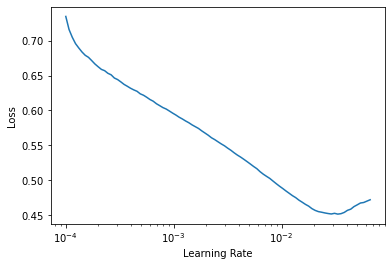

In [15]:
lr_min, lr_steep = featTo5emb_learn.lr_find (start_lr=1e-4, end_lr=0.1, num_it=100)

modelfile='Jane_nn5_'+str (HIDDEN_LAYERS).replace (' ', '_').replace (',', '').replace ('[', '').replace (']', '')
callbacks = [
    EarlyStoppingCallback (monitor='valid_loss', min_delta=0.00001, patience=20),
    SaveModelCallback (monitor='valid_loss', fname=modelfile),
    ReduceLROnPlateau (monitor='valid_loss', min_delta=0.0001, factor=2.0, min_lr=1e-8, patience=1),
    GradientClip (1.0)
]

epochs  = 1
lr      = lr_min
featTo5emb_learn.fit_one_cycle (epochs, lr, wd=1e-2, cbs=callbacks)
EMB5_MODEL = featTo5emb_learn.model.float ()
EMB5_MODEL = EMB5_MODEL.eval ()

# Create time series Dataset for self attention

In [16]:
def createLastRecords ():
    LAST_RECORDS = [[0.0] * 5]*HIST_LEN
    LAST_RECORDS = np.array (LAST_RECORDS)
    return LAST_RECORDS

LAST_RECORDS = createLastRecords ()
LAST_RECORDS.shape

(500, 5)

In [17]:
class JaneDataset (Datasets):
    
    def __init__(self, df, tfms=None, n_inp=1):
        
        super (JaneDataset, self).__init__(df.reset_index (drop=True).iloc[:, range(5)], tfms=tfms, n_inp=n_inp)        
        self.labels = None                         #;print ('df.shape =', df.shape)
        if df.shape[1] > 5:
            self.labels = df.reset_index (drop=True)[R_COLS]    
        # print ('df.shape=',df.shape, 'labels.shape=', self.labels.shape)
        return
    
    def __len__(self):
        return len (self.items)
    
    def __getitem__(self, idx: int):
        
        global LAST_RECORDS
        # if torch.is_tensor (idx):
        #     idx = idx.tolist ()
        label = None
        if self.labels is not None:
            label = self.labels.loc[idx].to_numpy ()  #.reshape ((-1,5))
        if idx-HIST_LEN+1 >= 0:
            idx = range (idx-HIST_LEN+1, idx+1)
        else:
            idx = range (0, idx+1)
        
        sample   = None
        if isinstance (self.items, pd.DataFrame):
            features = np.array (self.items.loc[idx]).reshape ((-1, 5))
        else:
            features = self.items[idx].reshape ((-1, 5))
        
        # join with history
        if features.shape[0] == HIST_LEN:
            LAST_RECORDS = features
        else:
            LAST_RECORDS = np.vstack ((LAST_RECORDS, features))[-HIST_LEN:]
        
        if self.labels is not None:
            # return LAST_RECORDS.astype ('double'), label.astype ('double')
            return LAST_RECORDS, label.astype ('float32')
        else:
            return LAST_RECORDS

In [18]:
def getCustomDLs (df):
    
    # print ('df.shape =', df.shape)
    # features = torch.DoubleTensor (df[F_COLS].to_numpy())
    features   = torch.Tensor (df[F_COLS].to_numpy().astype ('float32'))
    
    labels     = df[R_COLS].astype ('float32')
    df         = pd.concat ([pd.DataFrame (EMB5_MODEL (None, features)), labels], axis=1)    #;print ('df.shape =', df.shape)
    df.columns = ['logits_1', 'logits_2', 'logits_3', 'logits_4', 'logits_5'] + R_COLS
    df_valid   = df.sample (frac = 0.02)
    df_train   = df.drop (df_valid.index)
    del df
    df_valid.reset_index (drop = True, inplace=True)
    df_train.reset_index (drop = True, inplace=True)

    # pytorch Dataset
    tr_dataset = JaneDataset (df_train, n_inp=1)     #;print (tr_dataset[1])
    vl_dataset = JaneDataset (df_valid, n_inp=1)     #;print (vl_dataset[1])

    tr_datlder = DataLoader (tr_dataset, batch_size=BS)
    vl_datlder = DataLoader (vl_dataset, batch_size=BS)  
    return tr_datlder, vl_datlder

In [19]:
TRAIN_DL, VAL_DL = getCustomDLs (DF)

# Test the custom Dataloaders

In [20]:
TRAIN_DL.one_batch ()

(tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.1147, -0.0193, -0.2201, -0.3978, -0.3921]],
 
         [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.1147, -0.0193, -0.2201, -0.3978, -0.3921],
          [ 0.1147, -0.0193, -0.2201, -0.3978, -0.3921],
          [ 0.1135, -0.0282, -0.4621, -0.8808, -0.7457]],
 
         [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.1147, -0.0193, -0.2201, -0.3978, -0.3921],
          [ 0.1135, -0.0282, -0.4621,

In [21]:
TRAIN_DL.one_batch ()[0].shape,  TRAIN_DL.one_batch ()[1].shape

(torch.Size([1000, 500, 5]), torch.Size([1000, 5]))

In [22]:
VAL_DL.one_batch ()[0].shape,  VAL_DL.one_batch ()[1].shape

(torch.Size([100, 500, 5]), torch.Size([100, 5]))

In [23]:
sa_dls  = DataLoaders (TRAIN_DL, VAL_DL)
sa_dls.one_batch ()
sa_dls.train.one_batch () #[:self.dls.train.n_inp]
# sa_dls.train.n_inp
sa_dls.train.one_batch ()[:sa_dls.train.n_inp]

(tensor([[[ 0.1690,  0.1599,  0.1908,  0.2346,  0.2177],
          [-1.4163, -1.7203, -2.2066, -2.3680, -2.2783],
          [ 0.0573,  0.1005,  0.3653,  0.3411,  0.3582],
          ...,
          [-1.4471, -1.6748, -1.9631, -2.0124, -2.0135],
          [-0.2258, -0.2550, -0.2221, -0.2365, -0.2702],
          [ 0.1147, -0.0193, -0.2201, -0.3978, -0.3921]],
 
         [[ 0.0573,  0.1005,  0.3653,  0.3411,  0.3582],
          [-2.7502, -3.3928, -5.2118, -5.6234, -5.5497],
          [-1.2830, -1.6230, -2.1312, -2.1323, -2.1926],
          ...,
          [ 0.1147, -0.0193, -0.2201, -0.3978, -0.3921],
          [ 0.1147, -0.0193, -0.2201, -0.3978, -0.3921],
          [ 0.1135, -0.0282, -0.4621, -0.8808, -0.7457]],
 
         [[-3.1988, -3.9397, -5.9273, -6.1803, -6.1313],
          [-0.4592, -0.3984, -0.1925, -0.0342, -0.0385],
          [-0.4289, -0.5262, -0.8978, -1.3660, -1.2792],
          ...,
          [ 0.1147, -0.0193, -0.2201, -0.3978, -0.3921],
          [ 0.1135, -0.0282, -0.4621,

In [24]:
def future_mask (seq_length):
    future_mask = np.triu (np.ones ((seq_length, seq_length)), k=1).astype ('bool')
    return torch.from_numpy (future_mask)

In [25]:
class FFN (nn.Module):
    
    def __init__(self, embed_dim, outputCount=0, drop_prob=0.25, nonlin=nn.SiLU ()):
        
        super(FFN, self).__init__()
        
        self.nonlin     = nonlin
        self.dropout    = nn.Dropout (drop_prob)
        self.batchnorm0 = nn.BatchNorm1d (embed_dim)
        self.dense1     = nn.Linear (embed_dim, embed_dim)
        self.batchnorm1 = nn.BatchNorm1d (embed_dim)
        self.dense2     = nn.Linear (embed_dim, embed_dim)
        self.batchnorm2 = nn.BatchNorm1d (embed_dim)
        self.dense3     = nn.Linear (embed_dim, embed_dim)
        self.batchnorm3 = nn.BatchNorm1d (embed_dim)        
        self.outDense   = None
        if outputCount > 0:
            self.outDense   = nn.Linear (embed_dim, outputCount)
        self.outActivtn = None
        if outputCount == 1 or outputCount == 2:
            self.outActivtn = nn.Sigmoid ()
        elif outputCount > 0:
            self.outActivtn = nn.Softmax (dim=-1)
        return

    def forward (self, X, **kwargs):
        
        X = self.dropout (self.batchnorm0 (X))
        X = self.dropout (self.nonlin (self.batchnorm1 (self.dense1 (X))))
        X = self.dropout (self.nonlin (self.batchnorm2 (self.dense2 (X))))
        X = self.dropout (self.nonlin (self.batchnorm3 (self.dense3 (X))))
        if self.outActivtn:
            X = self.outActivtn (self.outDense (X))
        return X

In [26]:
class SANN_Model (nn.Module):
    
    def __init__(self, embed_dim=5, history_len=HIST_LEN, EMB5_MODEL=EMB5_MODEL):
        
        super (SANN_Model, self).__init__()
        self.history_len   = history_len
        self.embed_dim     = embed_dim
        self.pos_embedding = nn.Embedding (history_len, 5)        
        self.layer_normal  = nn.LayerNorm (embed_dim) 
        self.multi_att     = nn.MultiheadAttention (embed_dim=embed_dim, num_heads=5, dropout=0.2)
        self.ffn           = FFN (embed_dim, outputCount=0)
        self.dropout       = nn.Dropout (0.2)
        self.layer_normal  = nn.LayerNorm (embed_dim) 
        self.outDense      = nn.Linear (embed_dim, 5)
        # self.outActivtn  = nn.LogSoftmax (dim=1)
        # self.criterion   = nn.BCEWithLogitsLoss ()    # nn.NLLLoss ()
        self.EMB5_MODEL = EMB5_MODEL
        return
    
    
    def forward (self, x):
        """
        Potential methods:
            1. query_attn_feat     = self_attn (query_features, past_features, past_features)
            2. query_attn_feat_emb = self_attn (query_features, past_features, past_features_emb)
            3. query_attn_feat_emb = self_attn (query_features_emb, past_features_emb, past_features_emb)
        Now implementing (3.)
        """
        
        x    = x.double ()
        # x      = x.float ()
        # print ('x.shape =', x.shape) 
        
        # q is the last row of x
        q      = copy (x[:, -1, :]).view (-1, 1, 5)                  # (bs, 1, 5)
        x      = x.view (-1, self.history_len, 5)                    #;print ('x.shape =', x.shape)    # (bs, history_len, 5)
                
        pos_id = torch.arange (x.size (1)).unsqueeze (0)             #;print ('pos_id.shape   =', pos_id.shape)
        pos_x  = self.pos_embedding (pos_id)                         #;print ('pos_x.shape   =', pos_x.shape)
        x      = x + pos_x 
        
        x   = x.permute (1, 0, 2)                                     #"""x: [bs, history_len, embed] => [history_len, bs, embed]"""   #;print ('x.shape        =', x.shape)
        # q   = torch.unsqueeze (q, dim=0)                            #;print ('q.shape =', q.shape) 
        q   = q.permute (1, 0, 2)                                     #;print ('q.shape        =', q.shape)        
        att_mask = future_mask (x.size (0))
        
        # print ('x.shape =', x.shape) 
        # print ('q.shape =', q.shape) 
        # print ('att_mask.shape =', att_mask.shape) 
        att_output, att_weight = self.multi_att (q, x, x)             #;print ('att_output.shape = ', att_output.shape) 
        
        att_output = self.layer_normal (att_output + q)               #;print ('att_output.shape = ', att_output.shape) 
        att_output = att_output.permute (1, 0, 2)                     #;print ('att_output.shape = ', att_output.shape)  #;"""att_output: [s_len, bs, embed] => [bs, s_len, embed]""" ;print ('att_output.shape = ', att_output.shape) 
        att_output = att_output.squeeze (dim=1)                       #;print ('att_output.shape = ', att_output.shape) 
        
        x          = self.ffn (att_output)                            #;print ('x.shape = ', x.shape) 
        x          = self.layer_normal (x + att_output)               #;print ('x.shape = ', x.shape) 
        out_logits = self.outDense (x)                                #;print ('out_logits.shape = ', out_logits.shape) 
        return out_logits #.double ()

In [27]:
# path  = "../input/jane-fastai-nn5-150-150-150/Jane_nn5_150_150_150"
sa_dls  = DataLoaders (TRAIN_DL, VAL_DL)
learn   = Learner (sa_dls, SANN_Model ().double (), loss_func=nn.BCEWithLogitsLoss ()) #, model_dir='/kaggle/working/')
# learn = learn.load (path)

# learn.save ("jane-street-market-prediction/trained_model")
# learn = learn.load ("jane-street-market-prediction/trained_model")
learn.summary ()

SANN_Model (Input shape: 1000)
Layer (type)         Output Shape         Param #    Trainable 
                     1000 x 500 x 5      
Embedding                                 2500       True      
LayerNorm                                 10         True      
SiLU                                                           
Dropout                                                        
BatchNorm1d                               10         True      
Linear                                    30         True      
BatchNorm1d                               10         True      
Linear                                    30         True      
BatchNorm1d                               10         True      
Linear                                    30         True      
BatchNorm1d                               10         True      
Linear                                    30         True      
____________________________________________________________________________

Total params: 2,6

In [28]:
x, y = learn.dls.one_batch ()
print ('x.shape =', x.shape)                         #;print ('y.shape =', y.shape) 
pred_logits = learn.model (x)                        #;print ('pred_logits.shape =', pred_logits.shape) 
pred_logits

x.shape = torch.Size([1000, 500, 5])
y.shape = torch.Size([1000, 5])
pred_logits.shape = torch.Size([1000, 5])


tensor([[ 0.9455, -0.5942,  0.4903, -0.3560,  1.1739],
        [ 1.5712,  0.0036,  0.6950, -0.0885,  1.3030],
        [ 0.0557, -1.0890,  0.2227, -0.4048,  0.6166],
        ...,
        [-0.4199, -0.6235,  0.0856,  0.2979, -0.5493],
        [ 0.8664, -0.4603,  0.1332, -0.2366,  1.4755],
        [-0.2148, -1.1547,  0.0612, -0.3079,  0.3565]], dtype=torch.float64,
       grad_fn=<AddmmBackward>)

In [29]:
init_loss = learn.loss_func (pred_logits, y)
init_loss.backward ()
init_loss

tensor(0.7668, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

In [30]:
logits = learn.model (x)
logits

tensor([[ 0.9455, -0.5942,  0.4903, -0.3560,  1.1739],
        [ 1.5712,  0.0036,  0.6950, -0.0885,  1.3030],
        [ 0.0557, -1.0890,  0.2227, -0.4048,  0.6166],
        ...,
        [-0.4199, -0.6235,  0.0856,  0.2979, -0.5493],
        [ 0.8664, -0.4603,  0.1332, -0.2366,  1.4755],
        [-0.2148, -1.1547,  0.0612, -0.3079,  0.3565]], dtype=torch.float64,
       grad_fn=<AddmmBackward>)

(0.00660693421959877, 0.010964781977236271)

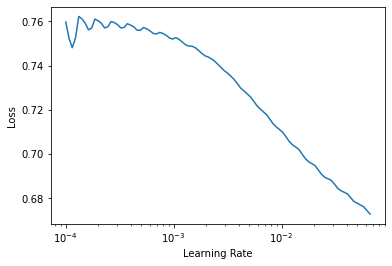

In [31]:
lr_min, lr_steep = learn.lr_find (start_lr=1e-4, end_lr=0.1, num_it=100)
lr_min, lr_steep

In [32]:
modelfile = 'Jane_sakt'
callbacks = [
    EarlyStoppingCallback (monitor='valid_loss', min_delta=0.00001, patience=20),
    SaveModelCallback (monitor='valid_loss', fname=modelfile),
    ReduceLROnPlateau (monitor='valid_loss', min_delta=0.0001, factor=2.0, min_lr=1e-5, patience=1),
    GradientClip (1.0)
]

epochs  = 1
lr      = lr_min
learn.fit_one_cycle (epochs, lr, wd=1e-2, cbs=callbacks)

epoch,train_loss,valid_loss,time
0,0.749765,0.750642,00:07


Better model found at epoch 0 with valid_loss value: 0.7506422400474548.


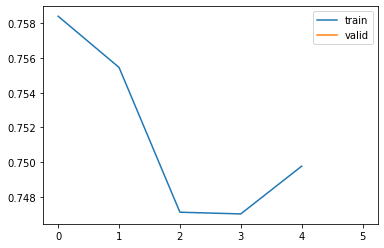

In [33]:
learn.recorder.plot_loss (skip_start=0, with_valid=True)

In [34]:
from fastai.imports import *
from fastai.torch_core import *
from fastai.learner import *
    
@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()

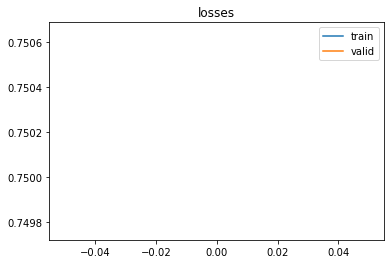

In [35]:
learn.recorder.plot_metrics ()

In [36]:
# learn.recorder.plot_lr ()

# Prediction

In [37]:
MODEL = learn.model
MODEL

SANN_Model(
  (pos_embedding): Embedding(500, 5)
  (layer_normal): LayerNorm((5,), eps=1e-05, elementwise_affine=True)
  (multi_att): MultiheadAttention(
    (out_proj): _LinearWithBias(in_features=5, out_features=5, bias=True)
  )
  (ffn): FFN(
    (nonlin): SiLU()
    (dropout): Dropout(p=0.25, inplace=False)
    (batchnorm0): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dense1): Linear(in_features=5, out_features=5, bias=True)
    (batchnorm1): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dense2): Linear(in_features=5, out_features=5, bias=True)
    (batchnorm2): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dense3): Linear(in_features=5, out_features=5, bias=True)
    (batchnorm3): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (outDense): Linear(in_features=5, out_features=5, bias=True)


In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils.rnn as rnn_utils
from   torch.autograd import Variable
from   torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

DEVICE = torch.device ("cuda:0") if torch.cuda.is_available () else torch.device ("cpu")

In [39]:
# EMB5_MODEL = EMB5_MODEL.double ()

In [40]:
LAST_RECORDS = createLastRecords ()
LAST_RECORDS.shape

(500, 5)

In [41]:
def predict_torch (test_df):
    
    test_df.drop (columns=['weight', 'date'], inplace=True)
    test_df.reset_index (drop=True, inplace=True)                                   #;print (test_df.head())
    test_df = torch.DoubleTensor (PIPE.transform (test_df))                         #;print ('test_df.shape =', test_df.shape)
    test_df = pd.DataFrame (EMB5_MODEL (None, test_df).detach ().numpy ())
    test_df.columns = ['Label_1', 'Label_2', 'Label_3', 'Label_4', 'Label_5', ]     #;print (test_df.head())
    test_dataset = JaneDataset (test_df, n_inp=1)
    pred = []
    for i in range (len (test_dataset)):

        batch     = test_dataset[i]
        batch     = torch.FloatTensor (batch).view (-1, HIST_LEN, 5)      #;print ('batch.shape =', batch.shape)  #.to (DEVICE).float ()
        pred_prob = torch.sigmoid (MODEL (batch)).detach ().cpu ().numpy ()
        pred.append (pred_prob)

    pred = np.concatenate (pred, axis=0).reshape ((-1, 5))
    pred = np.median (pred, axis=1)
    return np.where (pred >= 0.5, 1, 0).astype (int)

dtype = {
    'date'      : 'int64', 
    'weight'    : 'float32',
    'feature_0' : 'float32'
}
for i in range (1, 130):
    k = 'feature_' + str (i)
    dtype[k] = 'float32'
test_df = pd.read_csv ('../input/jane-street-market-prediction/train.csv.dummy', dtype=dtype)
    
test_df = test_df.drop (columns=R_COLS+['ts_id'])[:10]
predict_torch (test_df)

# Test

In [43]:
import janestreet
env      = janestreet.make_env ()  # initialize the environment
env_iter = env.iter_test ()        # an iterator which loops over the test set

ModuleNotFoundError: No module named 'janestreet'

# For direct submission, without using the Trainer class

In [ ]:
threshold = 0.50

for test_df, pred_df in env_iter:
    if test_df["weight"].item () > 0:
        
        pred_df.action = predict_torch (test_df)
    else:
        pred_df.action = 0
        
    env.predict (pred_df)

In [ ]:
print ('Done !')